# Quantum Computing Project

https://arxiv.org/pdf/1712.00854.pdf



In [2]:
import numpy as np
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

In [3]:
from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [4]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [5]:
backendQ = provider.get_backend('ibmqx2')
backendQ

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

## Demonstration of creating an entangled state

The circuit given below is a sub-circuit of the one present in the paper. This small circuit is just for demonstration of creation of entangled state b/w two qubits

In [5]:
circuit = QuantumCircuit(2, 2)

In [6]:
circuit.h(0)
circuit.h(0)
circuit.h(1)
circuit.cx(1, 0)
circuit.h(0)
circuit.h(1)

In [7]:
circuit.measure([0,1], [0,1])

In [8]:
circuit.draw()



Total count for 00 and 11 are: {'00': 477, '11': 523}


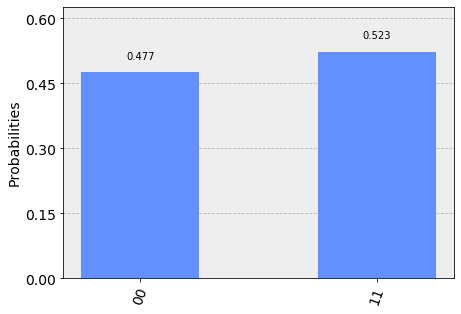

In [9]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=1000)
result = job.result()
counts = result.get_counts(circuit)
print("\nTotal count for 00 and 11 are:",counts)
plot_histogram(counts)

As can be seen, both qubits are entangled (Bell Pair - $ \frac{|00> + |11>}{\sqrt2} $)

## Entanglement Swapping using the actual circuit given in the paper

### Initial State

This part of the circuit creates the initial state, where (q_0, q_1) and (q_2, q_3) are entangled pairs. At the end of the experiment, we want to swap the entanglement b/w these two pairs.

In [1]:
# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

In [14]:
qR = QuantumRegister(5)
cR = ClassicalRegister(5)

circuit = QuantumCircuit(qR)


In [15]:
# Creating the entangled state. 

circuit.h(qR[0])
circuit.h(qR[0])
circuit.h(qR[1])
circuit.cx(qR[1], qR[0])
circuit.h(qR[0])
circuit.h(qR[1])


circuit.h(qR[2])
circuit.h(qR[2])
circuit.h(qR[3])
circuit.cx(qR[3], qR[2])
circuit.h(qR[2])
circuit.h(qR[3])

circuit.draw()

### Swapping the entanglement

In [16]:
circuit.cx(2,1)
circuit.h(1)
circuit.h(2)

circuit.cx(2,1)
circuit.h(1)
circuit.h(2)

circuit.cx(3,2)
circuit.h(3)
circuit.h(2)

circuit.cx(3,2)
circuit.h(3)
circuit.h(2)

circuit.cx(3,2)
circuit.h(2)
circuit.h(0)

circuit.cx(2,0)
circuit.h(2)
circuit.h(0)

circuit.cx(3,2)
circuit.h(3)
circuit.h(2)

circuit.cx(3,2)
circuit.h(3)
circuit.h(2)

circuit.cx(3,2)

msrC = QuantumCircuit(qR,cR)
msrC.measure([0,2], [0,2])


(circuit+msrC).draw()

In [123]:
#circuit.draw()

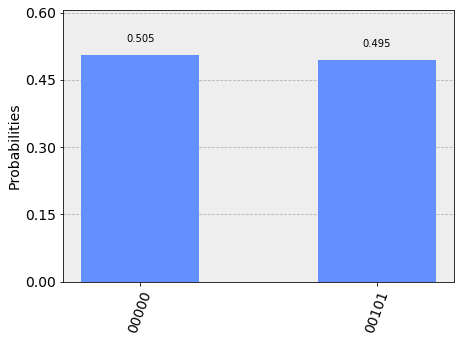

In [17]:
simulator = Aer.get_backend('qasm_simulator')

circ = circuit+msrC
result = execute(circ, simulator, shots=1000).result()
counts  = result.get_counts(circ)

# job = execute(circuit+msrC, simulator, shots=1000)
# result = job.result()
# counts = result.get_counts(circuit+msrC)
# #print("\nTotal count for 00 and 11 are:",counts)
plot_histogram(counts)

### Simulator Results

We measure q_0 and q_2. As can be seen, now q_0 and q_2 are entangled $ \frac{|00> + |11>}{\sqrt2} $ . That is, the entanglement has been swapped!

## Tomography


In [18]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector
# Needed for functions
import numpy as np
import time
from copy import deepcopy

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [19]:
# Create the ideal density matrix
q2 = QuantumRegister(2)
_bell = QuantumCircuit(q2)
_bell.h(q2[0])
_bell.h(q2[0])
_bell.h(q2[1])
_bell.cx(q2[1], q2[0])
_bell.h(q2[0])
_bell.h(q2[1])
print(_bell)

job = qiskit.execute(_bell, Aer.get_backend('statevector_simulator'))
psi_bell = job.result().get_statevector(_bell)
print(psi_bell)

         ┌───┐┌───┐┌───┐┌───┐
q3_0: |0>┤ H ├┤ H ├┤ X ├┤ H ├
         ├───┤└───┘└─┬─┘├───┤
q3_1: |0>┤ H ├───────■──┤ H ├
         └───┘          └───┘
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


### Ideal Density Matrix

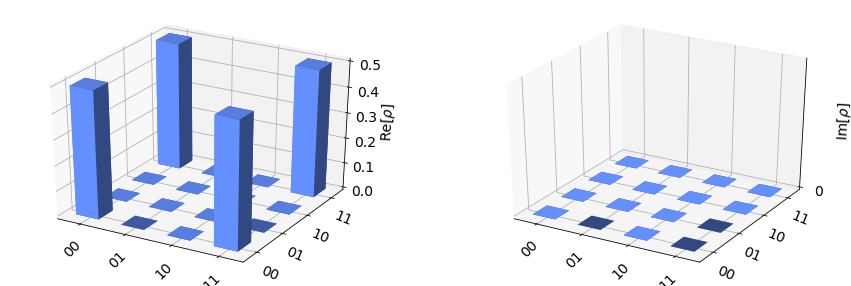

In [20]:
plot_state_city(psi_bell)

### Simulated Density Matrix


In [21]:
# NOTE::: This circuit shouldn't 
# Generate the state tomography circuits. Only pass in the 
# registers we want to measure (in this case 3 and 5)
qst_bell = state_tomography_circuits(circuit, [qR[0],qR[2]])
job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)

tomo_bell = StateTomographyFitter(job.result(), qst_bell)



In [22]:
# Perform the tomography fit
# which outputs a density matrix

# Need sqrt of this fidelity (as per the paper)
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity =', F_bell)

Fit Fidelity = 0.9972553282455792


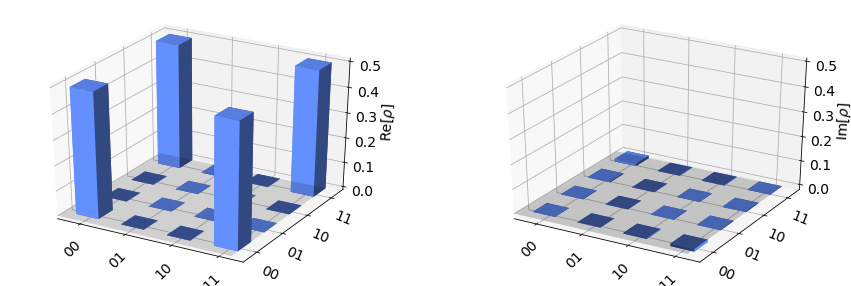

In [23]:
plot_state_city(rho_bell)


### Experimental Density Matrix

Have used ibmqx2 (instead of qx4 as per the paper, not available)

In [24]:
# NOTE::: This circuit shouldn't 
# Generate the state tomography circuits. Only pass in the 
# registers we want to measure (in this case 3 and 5)
qst_bell = state_tomography_circuits(circuit, [qR[0],qR[2]])
job_tomo = qiskit.execute(qst_bell, backendQ, shots=5000)

tomo_bell = StateTomographyFitter(job_tomo.result(), qst_bell)



In [25]:
# Perform the tomography fit
# which outputs a density matrix
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity =', F_bell)

Fit Fidelity = 0.39228996699376795


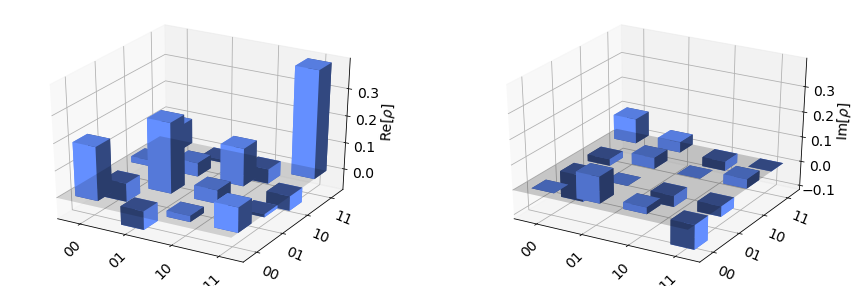

In [26]:
plot_state_city(rho_bell)


In [27]:

import math
print(math.sqrt(F_bell))

0.6263305572888552


The actual fidelity (as per the definition in the paper) is the square root of this value (F_Bell)

## Mitigation of Error


In [28]:
# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [29]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(5)
qubit_list = [0,2]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [122]:
#Add measurement noise
# List of lists is P(0|0), P(1|actual = 0); P(0|1), P(1|actual = 1);
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.7, 0.3],[0.2,0.8]])
    noise_model.add_readout_error(read_err,[qi])


In [123]:
# Execute the calibration circuits without noise
job = qiskit.execute(meas_calibs, backend=qiskit.Aer.get_backend('qasm_simulator'), shots=1000
                     , noise_model=noise_model)
cal_results = job.result()

In [124]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.48  0.134 0.124 0.034]
 [0.219 0.55  0.068 0.152]
 [0.217 0.059 0.59  0.162]
 [0.084 0.257 0.218 0.652]]


In [125]:
#meas_fitter = mc.CompleteMeasFitter(job_tomo.result(),state_labels)

In [126]:
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')

In [127]:
tomo_bell_2 = StateTomographyFitter(correct_tomo_results, qst_bell)

In [128]:
rho_bell_2 = tomo_bell_2.fit()
F_bell = state_fidelity(psi_bell, rho_bell_2)
print('Fit Fidelity (w/ correction) =', F_bell)

Fit Fidelity (w/ correction) = 0.5907220202627772


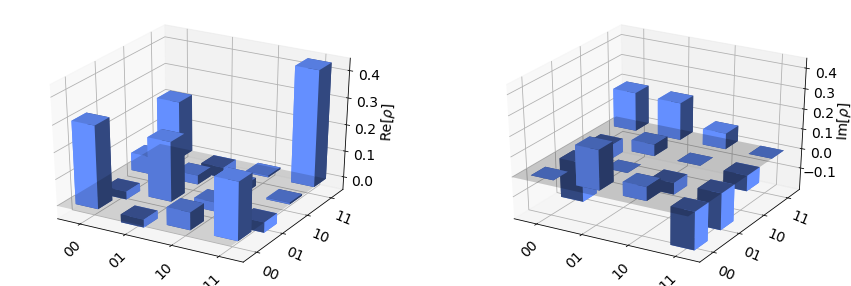

In [129]:
plot_state_city(rho_bell_2)


In [130]:

import math
print(math.sqrt(F_bell))

0.768584426242672


## Simplified Circuit

In [10]:
qRSim = QuantumRegister(5)
cRSim = ClassicalRegister(5)

circuitSim = QuantumCircuit(qRSim)

circuitSim.h(qRSim[0])
circuitSim.cx(qRSim[0], qRSim[1])

circuitSim.h(qRSim[2])
circuitSim.cx(qRSim[2], qRSim[3])

circuitSim.draw()

In [11]:
circuitSim.cx(2,1)

circuitSim.cx(1,2)
# Now there is entanglement b/w q[0] and q[2]

circuitSim.cx(3,2)


circuitSim.cx(2,3)


circuitSim.cx(3,2)
# q[2] and q[3] have been swapped

circuitSim.cx(0,2)


circuitSim.cx(3,2)


circuitSim.cx(2,3)


circuitSim.cx(3,2)

msrCSim = QuantumCircuit(qRSim,cRSim)
msrCSim.measure([0,2], [0,2])

(circuitSim+msrCSim).draw()

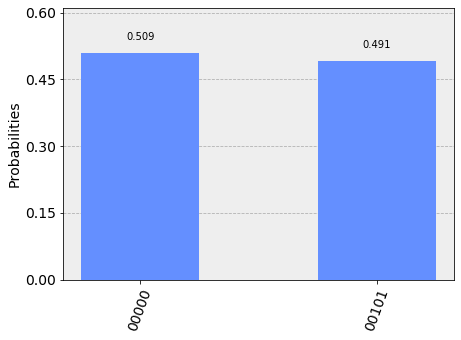

In [16]:
simulator = Aer.get_backend('qasm_simulator')

circSim = circuitSim+msrCSim
resultSim = execute(circSim, simulator, shots=1000).result()
countsSim = resultSim.get_counts(circSim)

# job = execute(circuit+msrC, simulator, shots=1000)
# result = job.result()
# counts = result.get_counts(circuit+msrC)
# #print("\nTotal count for 00 and 11 are:",counts)
plot_histogram(countsSim)

In [21]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector
# Needed for functions
import numpy as np
import time
from copy import deepcopy

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [22]:
# NOTE::: This circuit shouldn't 
# Generate the state tomography circuits. Only pass in the 
# registers we want to measure (in this case 3 and 5)
qst_bellSim = state_tomography_circuits(circuitSim, [qRSim[0],qRSim[2]])
job_tomoSim = qiskit.execute(qst_bellSim, backendQ, shots=8192)

tomo_bellSim = StateTomographyFitter(job_tomoSim.result(), qst_bellSim)

# Perform the tomography fit
# which outputs a density matrix
rho_bellSim = tomo_bellSim.fit()
F_bellSim = state_fidelity(psi_bell, rho_bellSim)
print('Fit Fidelity =', F_bellSim)

Fit Fidelity = 0.2531614494164385


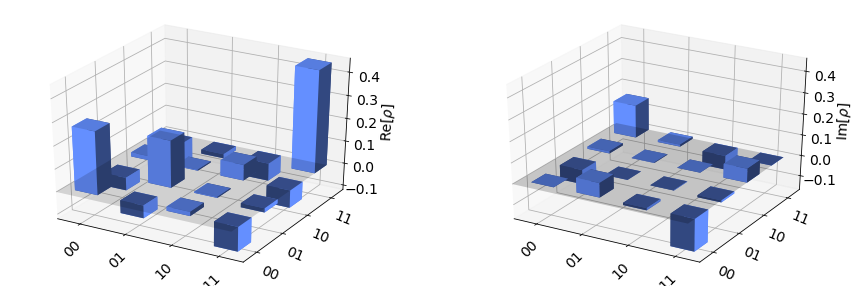

In [24]:
plot_state_city(rho_bellSim)


### Error Mitigation

In [63]:
# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

# Generate the calibration circuits
qrSim = qiskit.QuantumRegister(5)
qubit_list = [0,2]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qrSim, circlabel='mcal')

#Add measurement noise
# List of lists is P(0|0), P(1|actual = 0); P(0|1), P(1|actual = 1);
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.6, 0.4],[0.4,0.6]])
    noise_model.add_readout_error(read_err,[qi])

# Execute the calibration circuits without noise
job = qiskit.execute(meas_calibs, backend=qiskit.Aer.get_backend('qasm_simulator'), shots=1000
                     , noise_model=noise_model)
cal_results = job.result()

# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

correct_tomo_resultsSim = meas_fitter.filter.apply(job_tomoSim.result(), method='least_squares')

tomo_bell_2Sim = StateTomographyFitter(correct_tomo_resultsSim, qst_bellSim)

rho_bell_2Sim = tomo_bell_2Sim.fit()
F_bellSim = state_fidelity(psi_bell, rho_bell_2Sim)
print('Fit Fidelity (w/ correction) =', F_bellSim)

[[0.358 0.259 0.231 0.177]
 [0.228 0.339 0.167 0.247]
 [0.243 0.151 0.359 0.223]
 [0.171 0.251 0.243 0.353]]
Fit Fidelity (w/ correction) = 0.363392832752415


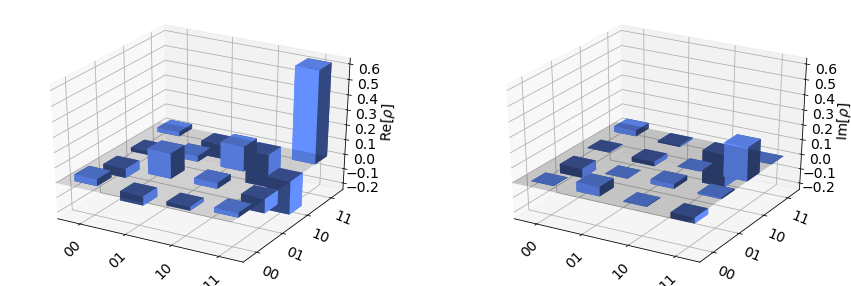

In [64]:
plot_state_city(rho_bell_2Sim)
